PINN to predict downstream flow

In [1]:
# libraries
import numpy as np
import deepxde as dde
import os
import torch

Using backend: pytorch



In [2]:
# import data reading functions
from convert_bin import read_bin, plot_v_fields

# take in data, splot into training and testing
# all of these are Nx by Ny by Nz
data_u, data_v, data_w = read_bin()

data_u = data_u.astype(np.single)
data_v = data_v.astype(np.single)
data_w = data_w.astype(np.single)
print(np.shape(data_u))

Nx, Ny, Nz = np.shape(data_u)[0], np.shape(data_u)[1], np.shape(data_u)[2]

(4096, 32, 32)


In [14]:
# split data up
# let's just use u velocities for now
u_in_train = data_u[0:1000, :, :]
u_out_train = data_u[1:1001, :, :]

u_in_test = data_u[4000:-1, :, :]
u_out_test = data_u[4001:, :, :]

# x y and z coordinates
# x coordinates not really important, might be nice for visualization later on
# these need to be rescaled based on simulation information
x = np.linspace(0, 1000, Nx)
y = np.linspace(-1, 1, Ny, dtype=np.single)
z = np.linspace(-1, 1, Nz, dtype=np.single)

Y, Z = np.meshgrid(y, z)

coords = np.concatenate((np.reshape(Y, (int(Ny*Nz),1)), np.reshape(Z, (int(Nz*Ny),1))), 1)
# print(coords)

u_in_train = np.reshape(u_in_train, (1000, 1, 32, 32))
u_in_test = np.reshape(u_in_test, (95, 1, 32, 32))
u_out_train = np.reshape(u_out_train, (1000, Ny*Nz))
u_out_test = np.reshape(u_out_test, (95, Ny*Nz))

X_train = (u_in_train, coords)
X_test = (u_in_test, coords)
# X-train sizes: 

data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=u_out_train, X_test=X_test, y_test=u_out_test)


In [15]:
print(len(X_test[0]))
print(len(X_test[1]))
print(np.size(u_out_train))

95
1024
1024000


In [16]:
print(np.shape(u_out_train))

(1000, 1024)


In [17]:
#some visualization, can probably make this prettier
# plot_v_fields(data_u, u_in_train, u_out_train, 20)

In [18]:
# PDE to learn: NS equations
def pde(x, y):

    return lhs - rhs

# no regular boundary or initial conditions
# apply data as point set BC



In [19]:
# convolution network class
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #add more layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=2, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 3)
        
#         self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.pool2 = torch.nn.MaxPool2d(kernel_size = 2)
        
        self.linear = torch.nn.Sequential(
                        torch.nn.Linear(400, 100),
                        torch.nn.ReLU(),
                        torch.nn.Linear(100, 20)
        )
        
        
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        
#         x = self.conv3(x)
#         x = self.pool2(x)
        
        #flatten
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = self.linear(x)

        x = self.logsoftmax(x)

        return x

In [20]:
# setup deepONet

m = 2
dim_x = 2

cnn = ConvNN()

net = dde.nn.DeepONetCartesianProd(
    [m, cnn],
    [dim_x, 20, 20],
    "relu",
    "Glorot normal",
)

Compiling model...
'compile' took 0.000375 s

Training model...

0         [7.93e+17]    [8.52e+17]    [8.61e-01]    
100       [7.93e+17]    [8.39e+17]    [8.54e-01]    

Best model at step 100:
  train loss: 7.93e+17
  test loss: 8.39e+17
  test metric: [8.54e-01]

'train' took 20.852264 s

Saving loss history to /home/andreas/meam_6010/FinalProject/WindPINN/Notebooks/loss.dat ...
Error: The network has multiple inputs, and saving such result han't been implemented.
Error: The network has multiple inputs, and plotting such result han't been implemented.


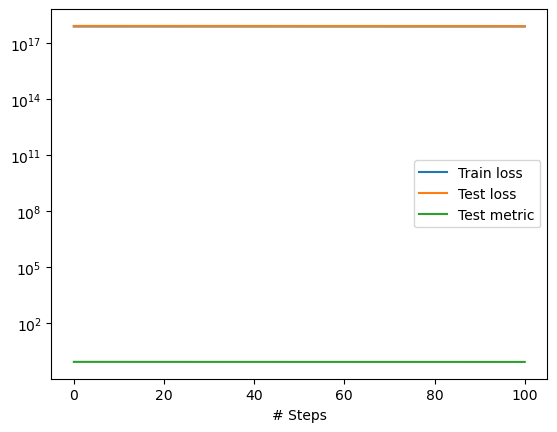

In [22]:
#compile model, train network
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=100)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)